## Counting Crashes In Proximity To A Work Zone
### This notebook creates and applies a methodology to calculate the number of crashes that happened close to a work zone. The number of crashes would be used after clustering to calculate crash probability in a cluster.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
from shapely import wkt

%pylab inline
# pylab.rcParams['figure.figsize'] = 12, 12
# pylab.rcParams['figure.dpi'] = 100

pd.set_option('mode.chained_assignment', None)

Populating the interactive namespace from numpy and matplotlib


## Importing the work zones data

In [2]:
df_wz = pd.read_csv('../data/cleaned_data/wz_subset.csv', parse_dates=['created_date', 'closed_date'])

# preparing the geometry column
df_wz['bounding_geometry'] = df_wz['bounding_geometry'].apply(wkt.loads)

# convert to geodataframe
gdf_wz = gpd.GeoDataFrame(df_wz, crs='EPSG:2263', 
                             geometry=df_wz.bounding_geometry)

gdf_wz.head(2)

,wz_id,segmentid,created_date,closed_date,created_season,closed_season,duration_days,purpose,geometry,length_ft,bounding_geometry,bounding_area
0,0_0,[32594],2017-02-02,2018-01-01,winter,winter,333,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985479.756 205496.239, 985088.432 ...",465.818036,LINESTRING (985479.7560875559 205496.239369042...,0.0
1,1001_0,[32568],2017-10-27,2017-11-15,fall,fall,19,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985410.519 204937.101, 985199.934 ...",250.365126,LINESTRING (985410.5192044964 204937.101001921...,0.0


In [3]:
gdf_wz.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Creating a buffer around the work zone

In [4]:
# claculate the average length of work zones
print(f'The everage length of work zones is {gdf_wz.length_ft.mean():.5} ft')

The everage length of work zones is 892.95 ft


#### We will use 900 ft to define the radius within which crashes are considered proximate to a work zone.

In [5]:
# make a buffer zone. radius = 900 ft based on the average work zone length
gdf_wz['buffer_geometry'] = pd.Series([l.minimum_rotated_rectangle.buffer(900) for i, l in gdf_wz.geometry.items()])
gdf_wz.head(2)

,wz_id,segmentid,created_date,closed_date,created_season,closed_season,duration_days,purpose,geometry,length_ft,bounding_geometry,bounding_area,buffer_geometry
0,0_0,[32594],2017-02-02,2018-01-01,winter,winter,333,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985479.756 205496.239, 985088.432 ...",465.818036,LINESTRING (985479.7560875559 205496.239369042...,0.0,"POLYGON ((984600.214479992 204992.8578009224, ..."
1,1001_0,[32568],2017-10-27,2017-11-15,fall,fall,19,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985410.519 204937.101, 985199.934 ...",250.365126,LINESTRING (985410.5192044964 204937.101001921...,0.0,"POLYGON ((984713.1585457764 204315.5136725391,..."


In [6]:
# assign buffer_geometry as the geometry column in the geodataframe
gdf_wz = gpd.GeoDataFrame(gdf_wz, geometry='buffer_geometry', crs='EPSG:2263')
print(gdf_wz.crs)
gdf_wz.info()

EPSG:2263
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2934 entries, 0 to 2933
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   wz_id              2934 non-null   object        
 1   segmentid          2934 non-null   object        
 2   created_date       2934 non-null   datetime64[ns]
 3   closed_date        2934 non-null   datetime64[ns]
 4   created_season     2934 non-null   object        
 5   closed_season      2934 non-null   object        
 6   duration_days      2934 non-null   int64         
 7   purpose            2934 non-null   object        
 8   geometry           2934 non-null   geometry      
 9   length_ft          2934 non-null   float64       
 10  bounding_geometry  2934 non-null   object        
 11  bounding_area      2934 non-null   float64       
 12  buffer_geometry    2934 non-null   geometry      
dtypes: datetime64[ns](2), float64(2), geometry(2)

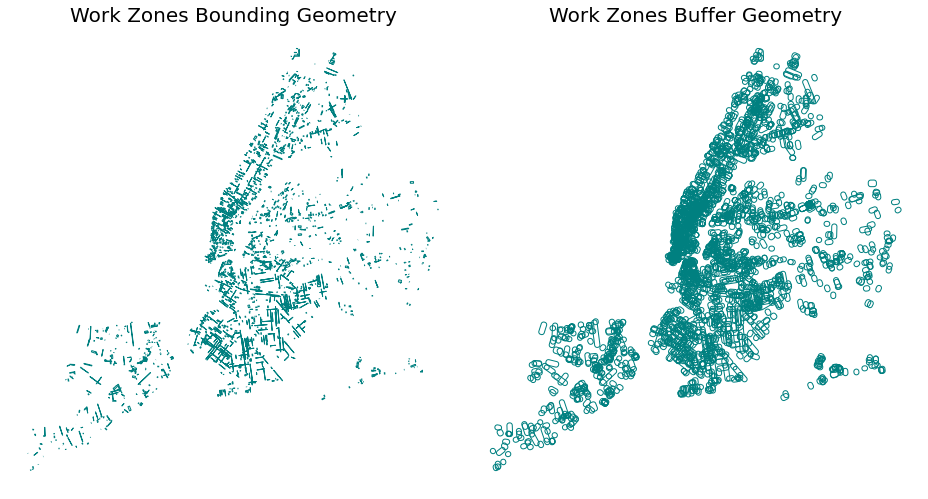

In [7]:
# Visualize the buffer zones created around work zones
fig, ax = plt.subplots(1,2, figsize=(13,7))

tmp = gpd.GeoDataFrame(gdf_wz, geometry='bounding_geometry', crs='EPSG:2263')
tmp.plot(facecolor='None', edgecolor='teal', ax=ax[0])
ax[0].set_title('Work Zones Bounding Geometry', fontsize=20)
ax[0].axis('off')

gdf_wz.plot(facecolor='None', edgecolor='teal', ax=ax[1])
ax[1].set_title('Work Zones Buffer Geometry', fontsize=20)
ax[1].axis('off')

plt.tight_layout()


## 2. Importing the collisions data

In [8]:
df_crash = pd.read_csv('../data/cleaned_data/wz_mv_collisions.csv', parse_dates=['crash_date'], 
                       usecols=['crash_date', 'collision_id', 'geometry'])

# preparing the geometry column
df_crash['geometry'] = df_crash['geometry'].apply(wkt.loads)

# convert to geodataframe
gdf_crash = gpd.GeoDataFrame(df_crash, crs = 'EPSG:4326',
                             geometry=df_crash.geometry)

gdf_crash.head()

,crash_date,collision_id,geometry
0,2017-02-02,3609669,POINT (-73.84871 40.83510)
1,2017-02-02,3610038,POINT (-73.91660 40.76464)
2,2017-02-02,3609888,POINT (-73.91417 40.82502)
3,2017-02-02,3608840,POINT (-73.92862 40.80059)
4,2017-02-02,3609477,POINT (-73.89581 40.88643)


In [9]:
print(gdf_crash.crs)
gdf_crash.info()

EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 632144 entries, 0 to 632143
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   crash_date    632144 non-null  datetime64[ns]
 1   collision_id  632144 non-null  int64         
 2   geometry      632144 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), int64(1)
memory usage: 14.5 MB


In [10]:
gdf_crash = gdf_crash.to_crs(epsg=2263)
print(gdf_crash.crs)
gdf_crash.head()

epsg:2263


,crash_date,collision_id,geometry
0,2017-02-02,3609669,POINT (1026114.785 243563.853)
1,2017-02-02,3610038,POINT (1007354.153 217866.941)
2,2017-02-02,3609888,POINT (1008004.348 239866.068)
3,2017-02-02,3608840,POINT (1004012.401 230963.227)
4,2017-02-02,3609477,POINT (1013060.447 262245.553)


In [11]:
# delete df_crash 
del df_crash

## 3. Counting Crashes

In [12]:
def count_crashes(start_date, end_date, buffer_zone):
    
    ''' a function that takes in the start and end dates of a work zone, 
    slice the crashes data on the corresponding time frame, 
    get the spatial index of crashes intersecting a work zone,
    and return their ids'''
    
    
    gdf_crashes_filtered = gdf_crash.loc[(gdf_crash['crash_date'] >= start_date) &
                                         (gdf_crash['crash_date'] <= end_date)]
    try:
        crashes_sindex = gdf_crashes_filtered.sindex
        possible_matches_index = list(crashes_sindex.intersection(buffer_zone.bounds))
        possible_matches = gdf_crashes_filtered.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(buffer_zone)]['collision_id'].tolist()
    except:
        precise_matches = []
    return precise_matches

In [13]:
# record time
import time
start_time = time.time()

gdf_wz['crash_list'] = gdf_wz.apply(lambda x:count_crashes(x['created_date'],
                                                   x['closed_date'],
                                                   x['buffer_geometry']), axis=1)

print("--- %s seconds to calculate 3000 workzones---" % (time.time() - start_time))

--- 5692.144979476929 seconds to calculate 3000 workzones---


In [14]:
gdf_wz['crash_count'] = gdf_wz['crash_list'].apply(lambda x:len(x))

In [15]:
gdf_wz.head()

,wz_id,segmentid,created_date,closed_date,created_season,closed_season,duration_days,purpose,geometry,length_ft,bounding_geometry,bounding_area,buffer_geometry,crash_list,crash_count
0,0_0,[32594],2017-02-02,2018-01-01,winter,winter,333,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985479.756 205496.239, 985088.432 ...",465.818036,"LINESTRING (985479.756 205496.239, 985088.432 ...",0.0,"POLYGON ((984600.214 204992.858, 984528.457 20...","[3666626, 3784199, 3636121, 3655994, 3743386, ...",132
1,1001_0,[32568],2017-10-27,2017-11-15,fall,fall,19,"[""['Occupancy Of Roadway As Stipulated']""]","LINESTRING (985410.519 204937.101, 985199.934 ...",250.365126,"LINESTRING (985410.519 204937.101, 985199.934 ...",0.0,"POLYGON ((984713.159 204315.514, 984641.304 20...","[3782864, 3784636, 3786322, 3780986, 3784142]",5
2,1003_0,[34055],2017-10-28,2017-10-29,fall,fall,1,"[""['Occupancy Of Roadway As Stipulated', 'Occu...","LINESTRING (988001.535 214967.278, 987214.942 ...",899.266732,"LINESTRING (988001.535 214967.278, 987214.942 ...",0.0,"POLYGON ((986778.752 214615.878, 986703.689 21...","[3778675, 3778854, 3778621, 3778677, 3779078]",5
3,1005_0,[33912],2017-10-28,2017-11-05,fall,fall,8,"[""['Occupancy Of Roadway As Stipulated', 'Occu...","LINESTRING (987508.942 212205.611, 986712.995 ...",906.130259,"LINESTRING (987508.942 212205.611, 986712.995 ...",0.0,"POLYGON ((986282.865 211848.108, 986207.448 21...","[3781005, 3783654, 3778680, 3781686, 3783453, ...",17
4,1007_0,[32823],2017-10-28,2017-11-15,fall,fall,18,"[""['Occupancy Of Roadway As Stipulated', 'Plac...","LINESTRING (986877.503 208974.449, 985986.349 ...",1019.691818,"LINESTRING (986877.503 208974.449, 985986.349 ...",0.0,"POLYGON ((985548.925 208683.497, 985473.936 20...","[3779844, 3787156, 3789994, 3781910, 3779868, ...",28


In [16]:
gdf_wz.crash_count.unique()

array([ 132,    5,   17,   28,    0,    1,    2,   16,  187,   96,   44,
          7,    3,   12,   15,   30,    4,   11,   23,   84,    6,   54,
         63,    8,  173,   88,   19,  164,    9,   42,   79,  903,   34,
         10,   94,  124,  175,   52,   25,   35,   95,   24,   50,  181,
         32,   29,   13,   14,   41,   36,  112,   82,  137,   21,   68,
         20,   18,  228,  283,   74,  492,   62,   49,   59,  281,  111,
        297,   55,   31,  232,  147,  776,   27,  161,  225,   39,  217,
         72,  104,  262,   37,   22,  196,   53,   38,  146,   26,   56,
        151,   69,   71,  192,  322,   90,   40,  246,   46,   76,  510,
        273,   47,   93,   75,   65,   66,  119,  179,   43,   61,   91,
        105,   97,   33,  128,   70,  133,  116,   77,   87,  237,  109,
        210,   86,  110,  150,  166,  595,  154,  176,  230,   67,   45,
         48,  224,  186,  152,  127,   60,   85,   57,  114,   51,   64,
        611,  315,   98,  434,  194,  102,  468,   

In [17]:
gdf_wz.crash_count.nunique()

215

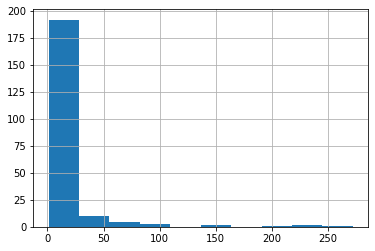

In [18]:
gdf_wz.crash_count.value_counts().hist()

In [19]:
gdf_wz.to_csv('../data/cleaned_data/wz_crashCount.csv', index=False)